In [1]:
import os
import pandas as pd

def parse_content(lines):
    data = {}
    for line in lines:
        # Split each line by ':', stripping any extra whitespace
        if ':' in line:
            column, value = line.strip().split(':', 1)
            data[column.strip()] = float(value.strip()) if value.strip().replace('.', '', 1).isdigit() else value.strip()
    return data

def parse_file(file_path):

    with open(file_path, 'r') as file:
        return parse_content(file.readlines())


# Discrete GPU

In [41]:
directory_path = "../Statistics/RTX4060_1280_720_3"

def read_statistics(folder):
    data_list = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.txt'):
            params = file_name.split(".")[0].split("_")[1:]
            file_path = os.path.join(folder, file_name)
            file_data = parse_file(file_path)
            file_data["Experiment"] = params[3]
            file_data["Model"] = params[1]
            data_list.append(file_data)

    special_columns = ["Model", "Experiment", "Renderer"]
    ms_columns = [
        'Average frame time',
        'Median frame time',
        '99th percentile frame time',
        '1th percentile frame time'
    ]

    df = pd.DataFrame(data_list)
    for column in df.columns:
        if column in special_columns:
            continue
        df[column] = pd.to_numeric(df[column]) 

    for column in ms_columns:
        df[column] *= 1000.0
    return df

df = read_statistics(directory_path)
df = df.sort_values(by="Renderer")


df.head()

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,400.0,0.0,0.553464,12.3677,16.0936,9.32712,93.7733,98.8547,35.743800,...,35.5312,35.5312,35.5312,46.663,21.430200,21.4921,21.8143,21.1640,1,Bunny
23,DirectX,1600.0,0.0,0.418881,21.9779,26.0041,14.19970,18.0934,28.1526,0.314540,...,21.9766,21.9766,21.9766,1594.120,0.627307,0.5728,0.9790,0.5369,1,Cube
24,DirectX,400.0,0.0,0.379521,22.4659,26.5029,14.94500,15.8159,17.6894,1.192400,...,21.9688,21.9688,21.9688,5923.030,0.168833,0.1462,0.3240,0.1346,2,Cube
25,DirectX,2000.0,0.0,0.404570,21.8926,28.1093,19.46520,17.9335,25.5938,0.209652,...,21.9766,21.9766,21.9766,1327.180,0.753477,0.6883,1.1625,0.6451,1,Cube
26,DirectX,200.0,0.0,0.374166,23.8137,28.0726,21.32100,17.4257,21.4122,15.239000,...,21.9688,21.9688,21.9688,8334.700,0.119980,0.1016,0.3020,0.0749,1,Cube


In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator, MultipleLocator

sns.set_palette(sns.color_palette("tab10", desat=1.0))
sns.set_style("whitegrid", {
    'axes.edgecolor': '#333333',  # darker borders
    'axes.linewidth': 1.3,
    'grid.color': '#444444',      # darker grid
    'grid.linewidth': 0.5,
})
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_palette(sns.dark_palette("white")[1:])

def plot_data(data, config, ax):
    linestyles = {
        "Vulkan": (5, 2),  # Dashed
        "OpenGL": (3, 2, 1, 2),  # Dash-dot
        "DirectX": ''  # Solid (no dashes)
    }

    sns.lineplot(data=data, x=config["x_column"], y=config["y_column"], hue="Renderer", style="Renderer", markers=True, dashes=linestyles, ax=ax, alpha=0.9)    
    ax.set_title(config["title"], fontsize=12)
    #ax.title.set_fontweight("bold")
    ax.set_xlabel(config["x_label"], fontsize=12)
    ax.set_ylabel(config["y_label"], fontsize=12)

    ax.set_xlim(left=0)
    min_val = min(data[config["y_column"]])
    for tick in ax.get_yticks()[::-1]:
        if tick <= min_val:
            ax.set_ylim(bottom=tick)
            break

    ax.xaxis.set_major_locator(MultipleLocator(int(max(data[config["x_column"]]) * 0.5)))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, steps=[5], integer=True, prune=None))

    ax.legend().remove()
    #ax.legend(title='Rendering API', loc="upper left", fontsize=12, ncol=3)

def convert_to_inches(cm):
    return tuple(x / 2.54 for x in cm)

def plot_grid(plot_config, figsize=(17, 8), title="", output=None):
    if type(plot_config) != list:
        dim_to_add = 2
    elif type(plot_config[0]) != list:
        dim_to_add = 1
    else:
        dim_to_add = 0

    for i in range(dim_to_add):
        plot_config = [plot_config]
    
    columns = max(len(row) for row in plot_config)
    rows = len(plot_config)
    print (convert_to_inches(figsize))
    fig, axs = plt.subplots(ncols=columns, nrows=rows, figsize=convert_to_inches(figsize))
    if rows == 1:
        axs = [axs]
    if columns == 1:
        for i in range(len(axs)):
            axs[i] = [axs[i]]

    for i in range(len(plot_config)):
        for j in range(len(plot_config[i])):
            config = plot_config[i][j]
            config["function"](config["data"], config["title"], axs[i][j])

    handles, labels = axs[0][0].get_legend_handles_labels()

    # Create a shared legend above all subplots
    legend = fig.legend(
        handles, labels,
        loc='upper center',
        ncol=3,
        frameon=True,
        bbox_to_anchor=(0.5, 1.0),
        fontsize=12
    )
    frame = legend.get_frame()
    frame.set_edgecolor('#333333')
    frame.set_linewidth(1)
    frame.set_alpha(1.0)

    #plt.suptitle(title, fontsize=12, fontweight="bold", y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.91])
    if output is not None:
        fig.savefig(output, dpi=300)
    plt.show()

def plot_avg_fps(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average FPS",
        "x_label": "Models",
        "y_label": "Frames per second",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average frame time",
        "x_label": "Models",
        "y_label": "Frame time, ms",
        "title": title
    }
    plot_data(data, config, ax)

def plot_median_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Median frame time",
        "x_label": "Models",
        "y_label": "Frame time, ms",
        "title": title
    }
    plot_data(data, config, ax)

def plot_99_percentile_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "99th percentile frame time",
        "x_label": "Models",
        "y_label": "Frame time, ms",
        "title": title
    }
    plot_data(data, config, ax)

def plot_1_percentile_frame_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "1th percentile frame time",
        "x_label": "Models",
        "y_label": "Frame time, ms",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_memory_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average memory usage",
        "x_label": "Models",
        "y_label": "MB",
        "title": title
    }
    plot_data(data, config, ax)

def plot_avg_cpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average CPU usage",
        "x_label": "Models",
        "y_label": "%",
        "y_min": 0,
        "y_max": 100,
        "title": title
    }
    plot_data(data, config, ax) 

def plot_avg_gpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average GPU usage",
        "x_label": "Models",
        "y_label": "%",
        "y_min": 0,
        "y_max": 100,
        "title": title
    }
    plot_data(data, config, ax) 

def plot_max_gpu_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Max GPU usage",
        "x_label": "Models",
        "y_label": "%",
        "y_min": 0,
        "y_max": 100,
        "title": title
    }
    plot_data(data, config, ax) 

def plot_avg_gpu_memory_usage(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Average GPU memory usage",
        "x_label": "Models",
        "y_label": "MB",
        "title": title
    }
    plot_data(data, config, ax) 

def plot_creation_time(data, title, ax):
    config = {
        "x_column": "Objects count",
        "y_column": "Creation time",
        "x_label": "Models",
        "y_label": "s",
        "title": title
    }
    plot_data(data, config, ax) 


#plot_avg_fps(df_bunny, "TTT")
#plot_avg_frame_time(df_bunny, "TTT")
#plot_1_percentile_frame_time(df_bunny, "TTT")
#plot_99_percentile_frame_time(df_bunny, "TTT")
#plot_avg_memory_usage(df_bunny, "TTT")
#plot_avg_cpu_usage(df_bunny, "TTT")
#plot_avg_gpu_usage(df_bunny, "TTT")
#plot_max_gpu_usage(df_bunny, "TTT")
#plot_avg_gpu_memory_usage(df_bunny, "TTT")

(6.692913385826771, 3.149606299212598)


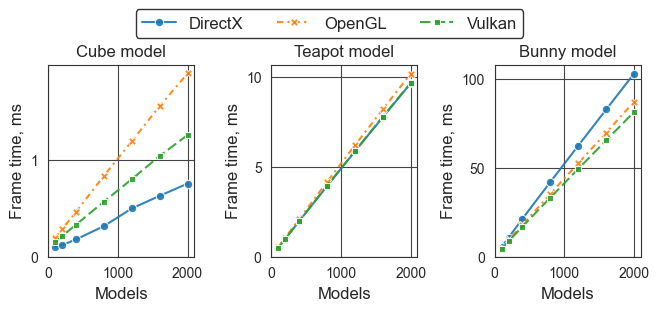

In [45]:
df_bunny_1 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1")]
df_cube_1 = df[(df["Model"] == "Cube") & (df["Experiment"] == "1")]
df_teapot_1 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "1")]
avg_frame_time_bunny_config_1 = {"function": plot_avg_frame_time, "data": df_bunny_1, "title": "Bunny model"}
avg_frame_time_cube_config_1 = {"function": plot_avg_frame_time, "data": df_cube_1, "title": "Cube model"}
avg_frame_time_teapot_config_1 = {"function": plot_avg_frame_time, "data": df_teapot_1, "title": "Teapot model"}

plot_grid([avg_frame_time_cube_config_1, avg_frame_time_teapot_config_1, avg_frame_time_bunny_config_1],
          figsize=(17, 8),
          title="Average frame time based on number of models for dynamic experiment\n(Discrete GPU)",
          output="../Images/avg-frame-time-experiment-1-discrete.png")

(6.692913385826771, 3.149606299212598)


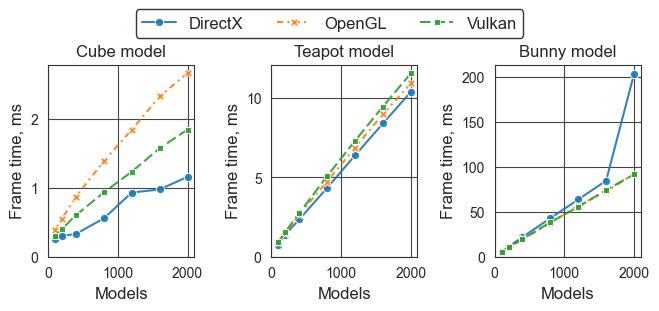

In [5]:
percentile_99_frame_time_bunny_config_1 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_1 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}
percentile_99_frame_time_teapot_config_1 = {"function": plot_99_percentile_frame_time, "data": df_teapot_1, "title": "Teapot model"}

plot_grid([percentile_99_frame_time_cube_config_1, percentile_99_frame_time_teapot_config_1, percentile_99_frame_time_bunny_config_1],
          figsize=(17, 8),
          title="99th percentile of frame time based on number of models for dynamic experiment\n(Discrete GPU)",
          output="../Images/99-percentile-frame-time-experiment-1-discrete.png")

In [6]:
models = ["Cube", "Teapot", "Bunny"]
hardest_case = None
for m in models:
    model_fps = df[(df["Model"] == m) & (df["Experiment"] == "1") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]].sort_values(by="Renderer").reset_index()
    model_fps = model_fps.drop(["index"], axis=1)
    if hardest_case is None:
        hardest_case = model_fps[["Renderer"]]
    column = f"FPS {m}"
    hardest_case[column] = model_fps["Average FPS"]
hardest_case.head()

,Renderer,FPS Cube,FPS Teapot,FPS Bunny
0,DirectX,1327.180,103.5930,9.69966
1,OpenGL,529.658,98.1212,11.45090
2,Vulkan,797.617,103.3170,12.27190


(6.692913385826771, 3.149606299212598)


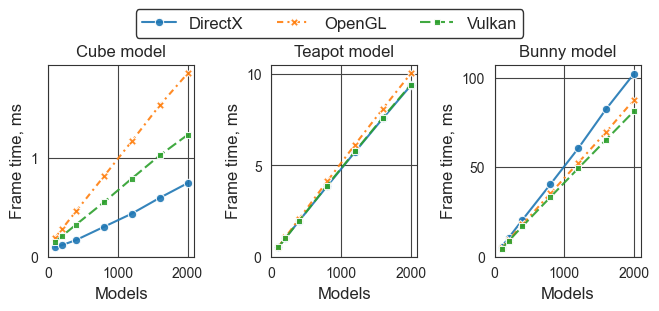

In [7]:
df_bunny_2 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2")]
df_cube_2 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2")]
df_teapot_2 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "2")]

avg_frame_time_bunny_config_2 = {"function": plot_avg_frame_time, "data": df_bunny_2, "title": "Bunny model"}
avg_frame_time_cube_config_2 = {"function": plot_avg_frame_time, "data": df_cube_2, "title": "Cube model"}
avg_frame_time_teapot_config_2 = {"function": plot_avg_frame_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_frame_time_cube_config_2, avg_frame_time_teapot_config_2, avg_frame_time_bunny_config_2],
          figsize=(17, 8),
          title="Average frame time based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/avg-frame-time-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


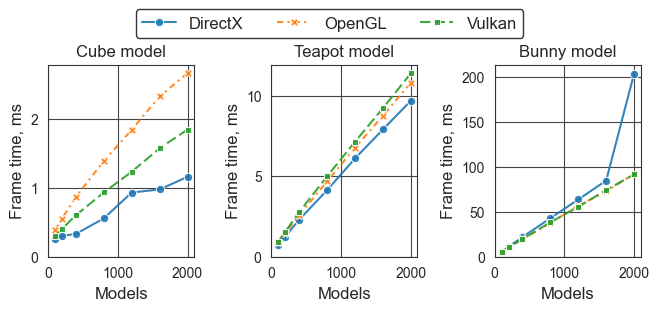

In [8]:
percentile_99_frame_time_bunny_config_2 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_2 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}
percentile_99_frame_time_teapot_config_2 = {"function": plot_99_percentile_frame_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([percentile_99_frame_time_cube_config_2, percentile_99_frame_time_teapot_config_2, percentile_99_frame_time_bunny_config_2],
          figsize=(17, 8),
          title="99th percentile of frame time based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/99-percentile-frame-time-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


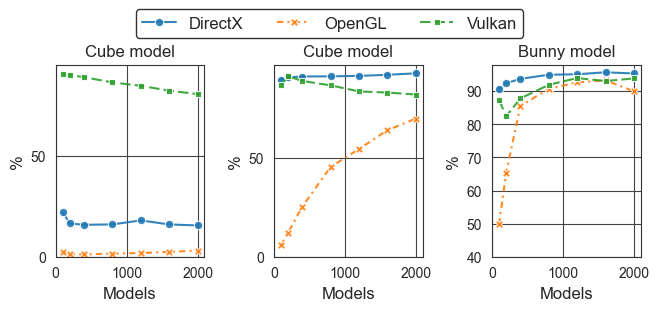

In [9]:
avg_gpu_usage_bunny_config = {"function": plot_avg_gpu_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_gpu_usage_cube_config = {"function": plot_avg_gpu_usage, "data": df_cube_2, "title": "Cube model"}
avg_gpu_usage_teapot_config = {"function": plot_avg_gpu_usage, "data": df_teapot_2, "title": "Cube model"}

plot_grid([avg_gpu_usage_cube_config, avg_gpu_usage_teapot_config, avg_gpu_usage_bunny_config],
          figsize=(17, 8),
          title="Average GPU usage based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/avg-gpu-usage-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


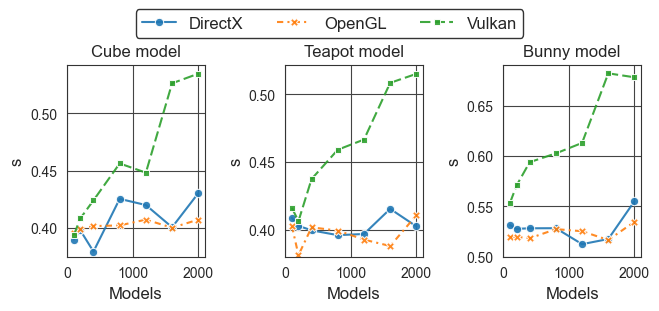

In [10]:
creation_time_bunny_config = {"function": plot_creation_time, "data": df_bunny_2, "title": "Bunny model"}
creation_time_cube_config = {"function": plot_creation_time, "data": df_cube_2, "title": "Cube model"}
creation_time_teapot_config = {"function": plot_creation_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([creation_time_cube_config, creation_time_teapot_config, creation_time_bunny_config],
          figsize=(17, 8),
          title="Initialization time based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/creation-time-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


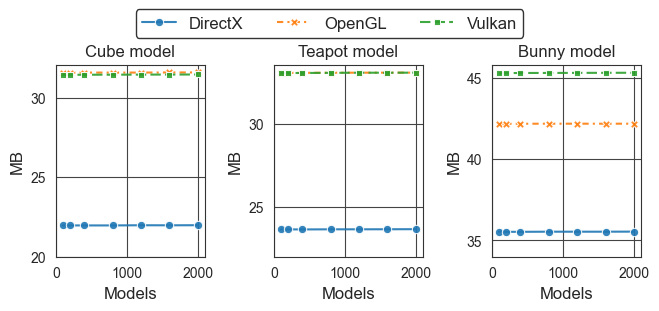

In [11]:
avg_ram_bunny_config = {"function": plot_avg_gpu_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_gpu_memory_usage, "data": df_cube_2, "title": "Cube model"}
avg_ram_teapot_config = {"function": plot_avg_gpu_memory_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_ram_cube_config, avg_ram_teapot_config, avg_ram_bunny_config],
          figsize=(17, 8),
          title="Average GPU memory usage based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/avg-gpu-memory-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


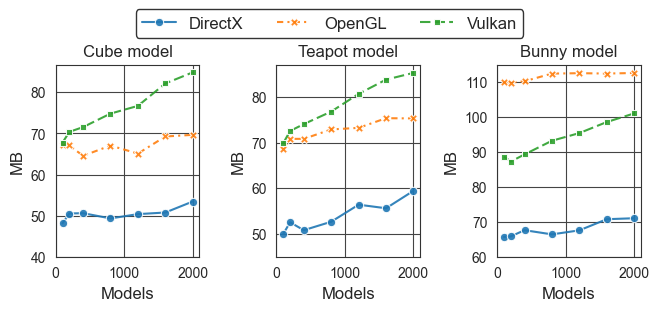

In [12]:
avg_ram_bunny_config = {"function": plot_avg_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_memory_usage, "data": df_cube_2, "title": "Cube model"}
avg_ram_teapot_config = {"function": plot_avg_memory_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_ram_cube_config, avg_ram_teapot_config, avg_ram_bunny_config],
          figsize=(17, 8),
          title="Average RAM usage based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/avg-ram-experiment-2-discrete.png")

(6.692913385826771, 3.149606299212598)


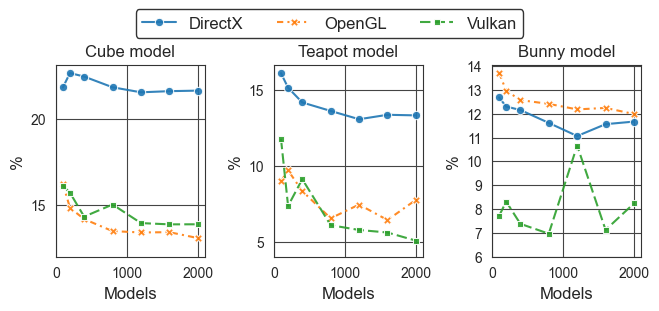

In [13]:
avg_ram_bunny_config = {"function": plot_avg_cpu_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_cpu_usage, "data": df_cube_2, "title": "Cube model"}
avg_ram_teapot_config = {"function": plot_avg_cpu_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_ram_cube_config, avg_ram_teapot_config, avg_ram_bunny_config],
          figsize=(17, 8),
          title="Average CPU usage based on number of models for static experiment\n(Discrete GPU)",
          output="../Images/avg-cpu-experiment-2-discrete.png")

In [14]:
models = ["Cube", "Teapot", "Bunny"]
hardest_case = None
for m in models:
    model_fps = df[(df["Model"] == m) & (df["Experiment"] == "2") & (df["Objects count"] == 2000)][["Renderer", "Average FPS"]].sort_values(by="Renderer").reset_index()
    model_fps = model_fps.drop(["index"], axis=1)
    if hardest_case is None:
        hardest_case = model_fps[["Renderer"]]
    column = f"FPS {m}"
    hardest_case[column] = model_fps["Average FPS"]
hardest_case.head()

,Renderer,FPS Cube,FPS Teapot,FPS Bunny
0,DirectX,1339.870,106.5840,9.76515
1,OpenGL,537.657,99.6213,11.38540
2,Vulkan,808.749,106.0800,12.28050


In [15]:
def read_repeated_statistics(folder):
    data_list = []
    for filename in os.listdir(folder):
        if ".txt" not in filename:
            continue
        path = os.path.join(folder, filename)
        params = filename.split(".")[0].split("_")[1:]
        with open(path) as f:
            parts = f.read().split("\n\n\n")[:-1]
        for part in parts:
            data = parse_content(part.split("\n"))
            data["Experiment"] = params[3]
            data["Model"] = params[1]
            data_list.append(data)

    special_columns = ["Model", "Experiment", "Renderer"]
    ms_columns = [
        'Average frame time',
        'Median frame time',
        '99th percentile frame time',
        '1th percentile frame time'
    ]

    df = pd.DataFrame(data_list)
    for column in df.columns:
        if column in special_columns:
            continue
        df[column] = pd.to_numeric(df[column]) 

    for column in ms_columns:
        df[column] *= 1000.0

    return df

repeated_folder ="../Statistics/RTX4060_Repeated_2"
df = read_repeated_statistics(repeated_folder)
df

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,2000.0,0.0,0.540505,11.72360,16.2894,8.55583,96.1139,100.0000,43.9171,...,35.5434,35.5508,35.5430,9.97048,100.29600,101.9870,204.5180,1.3280,2,Bunny
1,DirectX,2000.0,0.0,0.528896,11.82570,15.4488,9.33464,95.2428,100.0000,43.7769,...,35.5434,35.5508,35.5430,9.92793,100.72600,102.6910,177.4370,1.6549,2,Bunny
2,DirectX,2000.0,0.0,0.552342,11.62560,14.3859,8.00203,95.3831,100.0000,42.9794,...,35.5436,35.5547,35.5430,9.92848,100.72000,102.5700,208.9200,1.6163,2,Bunny
3,DirectX,2000.0,0.0,0.552070,11.39800,15.0001,9.13319,94.9118,100.0000,44.1255,...,35.5434,35.5508,35.5430,9.86117,101.40800,103.8930,178.0290,1.6330,2,Bunny
4,DirectX,2000.0,0.0,0.538963,12.23400,20.3825,7.50465,94.3016,100.0000,39.2959,...,35.5436,35.5547,35.5430,9.88474,101.16600,103.1000,191.4540,1.1686,2,Bunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Vulkan,2000.0,0.0,0.536639,9.42603,22.1804,2.89339,83.7464,94.2369,41.7762,...,33.0964,33.0977,33.0898,106.03900,9.43046,9.4416,11.4100,7.3284,2,Teapot
176,Vulkan,2000.0,0.0,0.526887,7.61427,14.9304,1.83955,85.8423,96.2063,42.0139,...,33.0964,33.0977,33.0898,105.80200,9.45164,9.4590,11.5424,7.2881,2,Teapot
177,Vulkan,2000.0,0.0,0.545619,7.57574,15.3901,2.10809,86.2469,96.2439,41.6098,...,33.0964,33.0977,33.0898,105.85600,9.44682,9.4472,11.6449,7.2948,2,Teapot
178,Vulkan,2000.0,0.0,0.549918,6.80972,13.6706,0.00000,83.7395,93.9884,41.4263,...,33.0964,33.0977,33.0898,106.01400,9.43274,9.4301,11.4458,7.4388,2,Teapot


In [16]:
import matplotlib.patches as mpatches

def create_distribution_plot(data, config, figsize=(13, 7), output=None):
    plt.figure(figsize=convert_to_inches(figsize))
    
    hatches = ["//", "\\\\", "xx"]
    ax = sns.histplot(
        data=data,
        x=config["x_column"],
        hue="Renderer",
        bins=int((data[config["x_column"]].max() - data[config["x_column"]].min()) / config["binwidth"]),
        multiple="dodge",
        edgecolor="black",
    )
    handles = ax.get_legend().legend_handles[::-1]
    labels = [t.get_text() for t in ax.get_legend().get_texts()][::-1]

    for i in range(len(ax.containers)):
        handle = handles[i]
        hatch = hatches[i]
        container = ax.containers[i]
        handle.set_hatch(hatch)

        for rectangle in container:
            rectangle.set_hatch(hatch)
    ax.get_legend().remove()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True, prune=None))
    ax.margins(x=0.05)
    fig = ax.get_figure()
    legend = fig.legend(
        handles, labels,
        loc='upper center',
        ncol=3,
        frameon=True,
        mode='expand',
        bbox_to_anchor=(0.102, 0.93, 0.886, 0.09),
        fontsize=12
    )

    frame = legend.get_frame()
    frame.set_edgecolor('#333333')
    frame.set_linewidth(1)
    frame.set_alpha(1.0)

    x_min = data[config['x_column']].min()
    x_max = data[config['x_column']].max()
    #plt.xlim(x_min - config["plot_range"], x_max + config["plot_range"])
    #fig.suptitle(config["title"], fontsize=12, fontweight="bold", y=1.02, x=0.55)
    plt.xlabel(config["x_label"], fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    if output is not None:
        plt.savefig(output, dpi=300)
    plt.show()


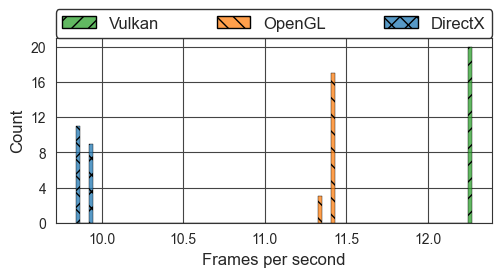

In [17]:
df_bunny_2000 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2") & (df["Objects count"] == 2000)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 0.08, "title": "Distribution of FPS for static experient on discrete GPU\n(2000 Bunny models)", "plot_range": 0.1} 
create_distribution_plot(df_bunny_2000, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-bunny-2000-discrete.png")

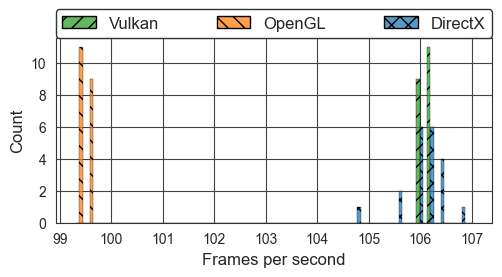

In [18]:
df_teapot_2000 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "2") & (df["Objects count"] == 2000)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 0.2, "title": "Distribution of FPS for static experient on discrete GPU\n(2000 Teapot models)", "plot_range": 1} 
create_distribution_plot(df_teapot_2000, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-teapot-2000-discrete.png")

In [19]:
from scipy import stats

def filter_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]    

def check_normality(data):
    filtered_data = filter_outliers(data)
    print("Filtered length:", len(filtered_data))
    stat, p = stats.normaltest(filtered_data)
    print("Shapiro-Wilk Test:")
    print("Statistic =", stat, "p-value =", p)
    if p < 0.05:
        print("Not normal")
    else:
        print("Normal")

def compare_normal_distributions(data1, data2):
    stat, p = stats.ttest_ind(data1, data2, alternative='less')

    print("One-tailed Independent T-Test:")
    print(f"t-statistic = {stat:.4f}, p-value = {p:.4f}")

    alpha = 0.05 
    if p < alpha:
        print("Reject the null hypothesis: data1 has a significantly smaller mean than data2")
    else:
        print("Fail to reject the null hypothesis: data1 does not have a significantly smaller mean than data2")

vulkan_fps = df_teapot_2000[df_teapot_2000["Renderer"] == "Vulkan"]["Average FPS"]
opengl_fps = df_teapot_2000[df_teapot_2000["Renderer"] == "OpenGL"]["Average FPS"]
directx_fps = df_teapot_2000[df_teapot_2000["Renderer"] == "DirectX"]["Average FPS"]
compare_normal_distributions(filter_outliers(vulkan_fps), filter_outliers(directx_fps))

One-tailed Independent T-Test:
t-statistic = -8.0631, p-value = 0.0000
Reject the null hypothesis: data1 has a significantly smaller mean than data2


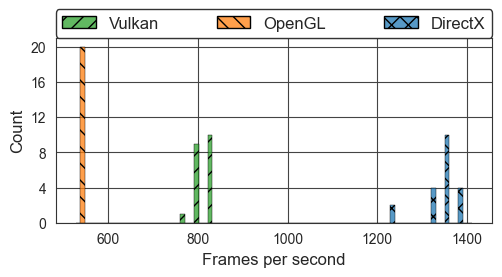

In [20]:
df_cube_2000 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2") & (df["Objects count"] == 2000)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 30, "title": "Distribution of FPS for static experient on discrete GPU\n(2000 Cube models)", "plot_range": 20} 
create_distribution_plot(df_cube_2000, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-cube-2000-discrete.png")

In [21]:
df[(df["Experiment"] == "2") & (df["Objects count"] == 2000)][["Renderer", "Average FPS", "Model"]].groupby(["Renderer", "Model"]).mean()

Average FPS
Renderer Model              
DirectX  Bunny      9.905579
         Cube    1353.073500
         Teapot   106.183800
OpenGL   Bunny     11.417365
         Cube     534.726200
         Teapot    99.477385
Vulkan   Bunny     12.251615
         Cube     798.820200
         Teapot   105.962700

# Integrated GPU

In [22]:
directory_path = "../Statistics/Integrated_1280_720_2/"
df = read_statistics(directory_path)
df = df.sort_values(by="Renderer")
df.head()

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,40.0,0.0,1.028250,4.60854,7.99054,0.712381,92.0859,96.5270,40.3500,...,29.6133,29.6133,29.6133,31.4239,31.822900,31.8037,36.9440,31.2988,1,Bunny
23,DirectX,40.0,0.0,1.100560,49.59730,97.64460,30.835700,86.2837,94.3299,37.3656,...,17.2930,17.2930,17.2930,901.4700,1.109300,1.0345,2.3206,0.4565,2,Cube
24,DirectX,4.0,0.0,0.815362,32.62960,37.22530,18.334100,91.6910,95.7639,45.3279,...,17.2578,17.2578,17.2578,1055.0500,0.947823,0.8966,2.5156,0.5549,2,Cube
25,DirectX,20.0,0.0,0.735398,35.03160,42.27080,18.956600,91.3770,95.0195,45.1538,...,17.2695,17.2695,17.2695,1015.4500,0.984781,0.9683,2.0085,0.4502,1,Cube
26,DirectX,60.0,0.0,0.734701,40.13500,73.84410,19.132700,84.4281,89.6376,42.7283,...,17.4727,17.4727,17.4727,875.7640,1.141860,1.0803,1.9231,0.4760,2,Cube


(6.692913385826771, 3.149606299212598)


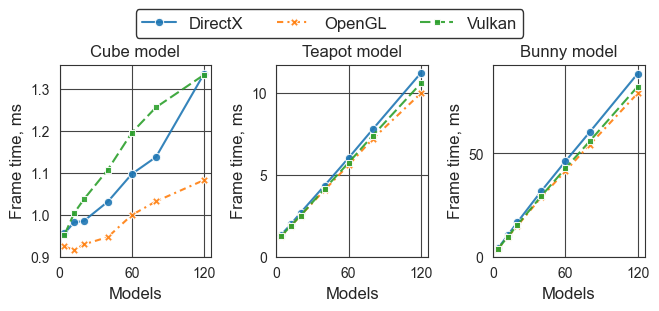

In [23]:
df_bunny_1 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "1")]
df_cube_1 = df[(df["Model"] == "Cube") & (df["Experiment"] == "1")]
df_teapot_1 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "1")]
avg_frame_time_bunny_config_1 = {"function": plot_avg_frame_time, "data": df_bunny_1, "title": "Bunny model"}
avg_frame_time_cube_config_1 = {"function": plot_avg_frame_time, "data": df_cube_1, "title": "Cube model"}
avg_frame_time_teapot_config_1 = {"function": plot_avg_frame_time, "data": df_teapot_1, "title": "Teapot model"}

plot_grid([avg_frame_time_cube_config_1, avg_frame_time_teapot_config_1, avg_frame_time_bunny_config_1],
          figsize=(17, 8),
          title="Average frame time based on number of models for dynamic experiment\n(Integrated GPU)",
          output="../Images/avg-frame-time-experiment-1-integrated.png")

(6.692913385826771, 3.149606299212598)


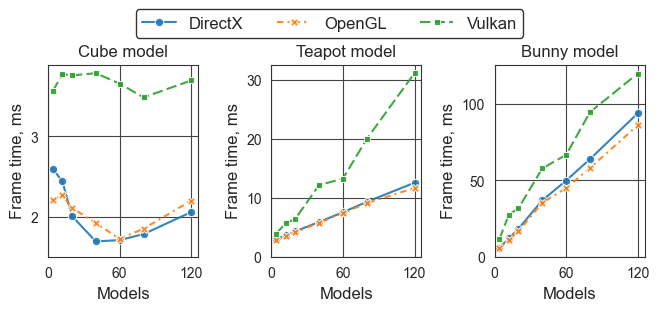

In [24]:
percentile_99_frame_time_bunny_config_1 = {"function": plot_99_percentile_frame_time, "data": df_bunny_1, "title": "Bunny model"}
percentile_99_frame_time_cube_config_1 = {"function": plot_99_percentile_frame_time, "data": df_cube_1, "title": "Cube model"}
percentile_99_frame_time_teapot_config_1 = {"function": plot_99_percentile_frame_time, "data": df_teapot_1, "title": "Teapot model"}

plot_grid([percentile_99_frame_time_cube_config_1, percentile_99_frame_time_teapot_config_1, percentile_99_frame_time_bunny_config_1],
          figsize=(17, 8),
          title="99th percentile of frame time based on number of models for dynamic experiment (Integrated GPU)",
          output="../Images/99-percentile-frame-time-experiment-1-integrated.png")

In [25]:
models = ["Cube", "Teapot", "Bunny"]
hardest_case = None
for m in models:
    model_fps = df[(df["Model"] == m) & (df["Experiment"] == "1") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]].sort_values(by="Renderer").reset_index()
    model_fps = model_fps.drop(["index"], axis=1)
    if hardest_case is None:
        hardest_case = model_fps[["Renderer"]]
    column = f"FPS {m}"
    hardest_case[column] = model_fps["Average FPS"]
hardest_case.head()

,Renderer,FPS Cube,FPS Teapot,FPS Bunny
0,DirectX,748.809,89.2499,11.2814
1,OpenGL,923.905,100.3350,12.6393
2,Vulkan,750.296,94.5566,12.1393


(6.692913385826771, 3.149606299212598)


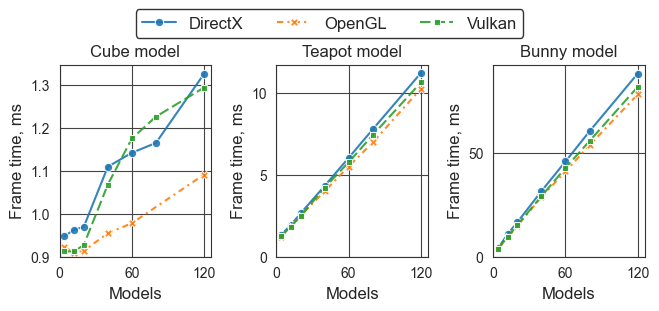

In [26]:
df_bunny_2 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2")]
df_cube_2 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2")]
df_teapot_2 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "2")]
avg_frame_time_bunny_config_2 = {"function": plot_avg_frame_time, "data": df_bunny_2, "title": "Bunny model"}
avg_frame_time_cube_config_2 = {"function": plot_avg_frame_time, "data": df_cube_2, "title": "Cube model"}
avg_frame_time_teapot_config_2 = {"function": plot_avg_frame_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_frame_time_cube_config_2, avg_frame_time_teapot_config_2, avg_frame_time_bunny_config_2],
          figsize=(17, 8),
          title="Average frame time based on number of models for static experiment (Integrated GPU)",
          output="../Images/avg-frame-time-experiment-2-integrated.png")

(6.692913385826771, 3.149606299212598)


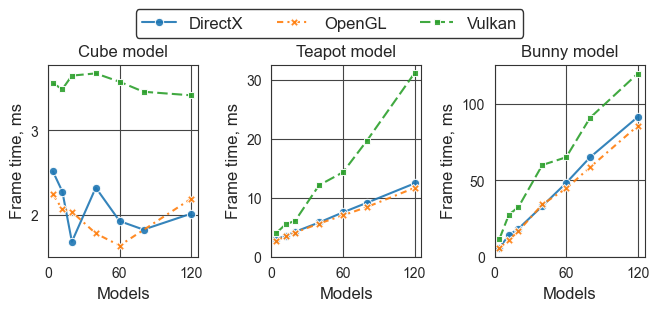

In [27]:
percentile_99_frame_time_bunny_config_2 = {"function": plot_99_percentile_frame_time, "data": df_bunny_2, "title": "Bunny model"}
percentile_99_frame_time_cube_config_2 = {"function": plot_99_percentile_frame_time, "data": df_cube_2, "title": "Cube model"}
percentile_99_frame_time_teapot_config_2 = {"function": plot_99_percentile_frame_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([percentile_99_frame_time_cube_config_2, percentile_99_frame_time_teapot_config_2, percentile_99_frame_time_bunny_config_2],
          figsize=(17, 8),
          title="99th percentile of frame time based on number of models for static experiment (Integrated GPU)",
          output="../Images/99-percentile-frame-time-experiment-2-integrated.png")

(6.692913385826771, 3.149606299212598)


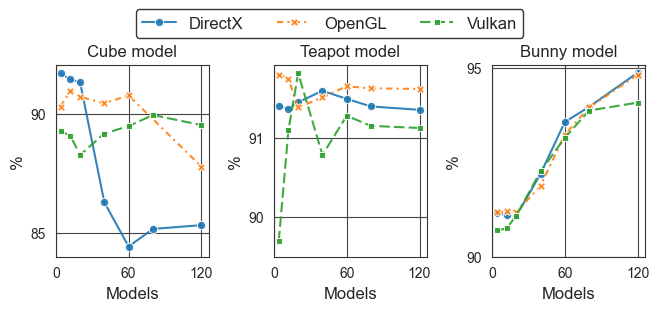

In [28]:
avg_gpu_usage_bunny_config = {"function": plot_avg_gpu_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_gpu_usage_cube_config = {"function": plot_avg_gpu_usage, "data": df_cube_2, "title": "Cube model"}
avg_gpu_usage_teapot_config = {"function": plot_avg_gpu_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_gpu_usage_cube_config, avg_gpu_usage_teapot_config, avg_gpu_usage_bunny_config],
          figsize=(17, 8),
          title="Average GPU usage based on number of models for static experiment (Integrated GPU)",
          output="../Images/avg-gpu-usage-experiment-2-integrated.png")

(6.692913385826771, 3.149606299212598)


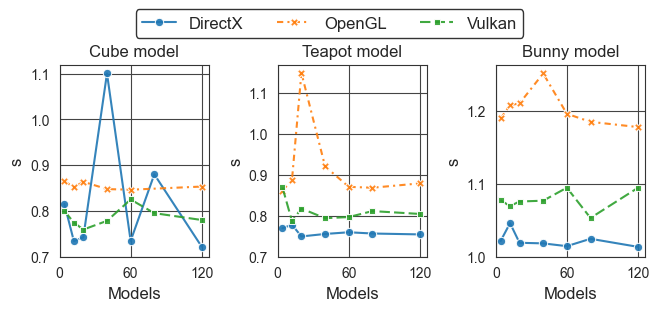

In [29]:
creation_time_bunny_config = {"function": plot_creation_time, "data": df_bunny_2, "title": "Bunny model"}
creation_time_cube_config = {"function": plot_creation_time, "data": df_cube_2, "title": "Cube model"}
creation_time_teapot_config = {"function": plot_creation_time, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([creation_time_cube_config, creation_time_teapot_config, creation_time_bunny_config],
          figsize=(17, 8),
          title="Initialization time based on number of models for static experiment (Integrated GPU)",
          output="../Images/creation-time-experiment-2-integrated.png")

(6.692913385826771, 3.149606299212598)


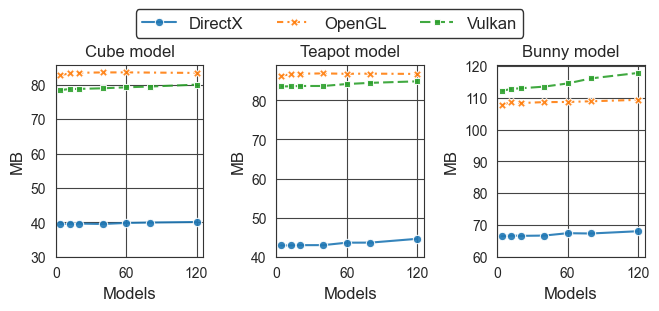

In [30]:
avg_ram_bunny_config = {"function": plot_avg_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_memory_usage, "data": df_cube_2, "title": "Cube model"}
avg_ram_teapot_config = {"function": plot_avg_memory_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_ram_cube_config, avg_ram_teapot_config, avg_ram_bunny_config],
          figsize=(17, 8),
          title="Average RAM usage based on number of models for static experiment (Integrated GPU)",
          output="../Images/avg-ram-experiment-2-integrated.png")

(6.692913385826771, 3.149606299212598)


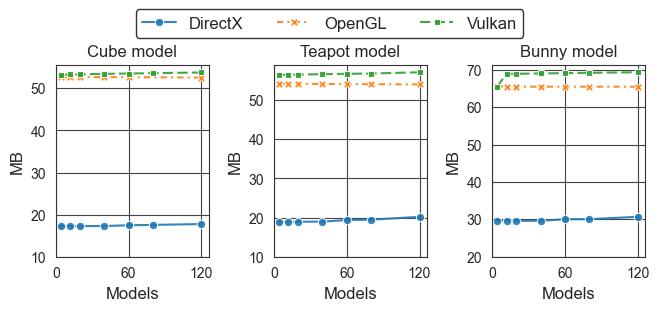

In [31]:
avg_ram_bunny_config = {"function": plot_avg_gpu_memory_usage, "data": df_bunny_2, "title": "Bunny model"}
avg_ram_cube_config = {"function": plot_avg_gpu_memory_usage, "data": df_cube_2, "title": "Cube model"}
avg_ram_teapot_config = {"function": plot_avg_gpu_memory_usage, "data": df_teapot_2, "title": "Teapot model"}

plot_grid([avg_ram_cube_config, avg_ram_teapot_config, avg_ram_bunny_config],
          figsize=(17, 8),
          title="Average GPU memory usage based on number of models for static experiment (Integrated GPU)",
          output="../Images/avg-gpu-memory-experiment-2-integrated.png")

In [32]:
models = ["Cube", "Teapot", "Bunny"]
hardest_case = None
for m in models:
    model_fps = df[(df["Model"] == m) & (df["Experiment"] == "2") & (df["Objects count"] == 120)][["Renderer", "Average FPS"]].sort_values(by="Renderer").reset_index()
    model_fps = model_fps.drop(["index"], axis=1)
    if hardest_case is None:
        hardest_case = model_fps[["Renderer"]]
    column = f"FPS {m}"
    hardest_case[column] = model_fps["Average FPS"]
hardest_case.head()

,Renderer,FPS Cube,FPS Teapot,FPS Bunny
0,DirectX,754.313,89.3666,11.3042
1,OpenGL,916.350,97.7724,12.7550
2,Vulkan,773.017,94.2109,12.1907


In [33]:
repeated_folder ="../Statistics/Integrated_Repeated_2/"
df = read_repeated_statistics(repeated_folder)
df

,Renderer,Objects count,Total number of vertices,Creation time,Average CPU usage,Max CPU usage,Min CPU usage,Average GPU usage,Max GPU usage,Min GPU usage,...,Average GPU memory usage,Max GPU memory usage,Min GPU memory usage,Average FPS,Average frame time,Median frame time,99th percentile frame time,1th percentile frame time,Experiment,Model
0,DirectX,120.0,0.0,1.045980,2.20855,6.33019,0.403314,94.7602,98.4652,41.2257,...,30.6836,30.6836,30.6836,11.3223,88.3210,89.4815,92.2355,6.6696,2,Bunny
1,DirectX,120.0,0.0,1.029410,2.58400,5.61649,0.667093,94.9117,98.5141,43.4714,...,30.6836,30.6836,30.6836,11.3223,88.3212,89.4645,92.5080,7.8718,2,Bunny
2,DirectX,120.0,0.0,1.039310,2.21479,6.01722,0.891543,94.8976,98.4027,43.5790,...,30.6836,30.6836,30.6836,11.3176,88.3583,89.5140,91.9511,6.1070,2,Bunny
3,DirectX,120.0,0.0,1.049800,2.59004,6.59418,0.788293,94.7616,98.4116,41.2847,...,30.6836,30.6836,30.6836,11.3180,88.3552,89.5129,91.7898,8.2203,2,Bunny
4,DirectX,120.0,0.0,1.037820,2.35684,5.01766,0.853792,94.8968,98.3861,43.3660,...,30.6836,30.6836,30.6836,11.3137,88.3888,89.5162,92.5857,9.5966,2,Bunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Vulkan,120.0,0.0,0.823458,9.46387,11.76300,7.672960,90.9969,94.0792,44.1631,...,57.1691,57.2266,57.1250,94.2689,10.6080,12.2800,31.2203,0.4151,2,Teapot
176,Vulkan,120.0,0.0,0.834123,9.45170,13.48500,6.892530,90.9694,94.2509,43.9766,...,57.1613,57.2266,57.1250,94.2740,10.6074,12.2239,31.1994,0.3946,2,Teapot
177,Vulkan,120.0,0.0,0.825476,9.06403,11.79040,6.914830,90.9567,94.1866,44.5173,...,57.1429,57.2266,57.1250,94.2835,10.6063,12.2289,31.3542,0.4561,2,Teapot
178,Vulkan,120.0,0.0,0.816488,9.76843,13.44200,5.296060,91.1083,94.1023,43.9872,...,57.1545,57.2266,57.1250,94.2712,10.6077,11.8197,31.3877,0.4449,2,Teapot


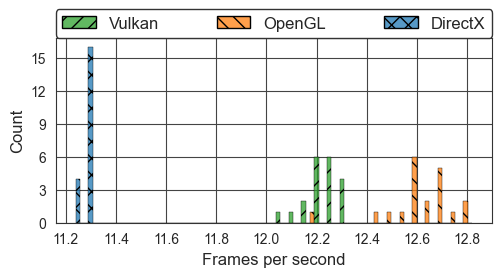

In [34]:
df_bunny_120 = df[(df["Model"] == "Bunny") & (df["Experiment"] == "2") & (df["Objects count"] == 120)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 0.05, "title": "Distribution of FPS for static experient on integrated GPU (120 Bunny models)", "plot_range": 0.3} 
create_distribution_plot(df_bunny_120, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-bunny-120-integrated.png")

In [35]:
vulkan_fps = df_bunny_120[df_bunny_120["Renderer"] == "Vulkan"]["Average FPS"]
opengl_fps = df_bunny_120[df_bunny_120["Renderer"] == "OpenGL"]["Average FPS"]
directx_fps = df_bunny_120[df_bunny_120["Renderer"] == "DirectX"]["Average FPS"]

check_normality(filter_outliers(vulkan_fps))
print()
check_normality(filter_outliers(opengl_fps))
print()
compare_normal_distributions(filter_outliers(vulkan_fps), filter_outliers(opengl_fps))

Filtered length: 19
Shapiro-Wilk Test:
Statistic = 2.2224232469921885 p-value = 0.32915990149840113
Normal

Filtered length: 19
Shapiro-Wilk Test:
Statistic = 0.0075918085217161965 p-value = 0.9962112910765708
Normal

One-tailed Independent T-Test:
t-statistic = -16.6851, p-value = 0.0000
Reject the null hypothesis: data1 has a significantly smaller mean than data2


C:\Users\maksp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\maksp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


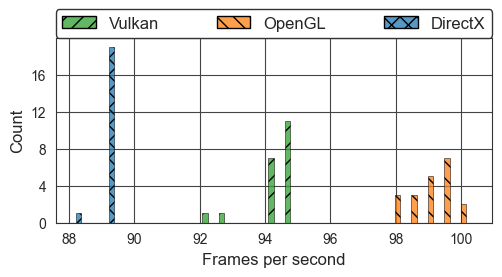

In [36]:
df_cube_120 = df[(df["Model"] == "Teapot") & (df["Experiment"] == "2") & (df["Objects count"] == 120)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 0.5, "title": "Distribution of FPS for static experient on integrated GPU (120 Teapot models)", "plot_range": 1} 
create_distribution_plot(df_cube_120, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-teapot-120-integrated.png")

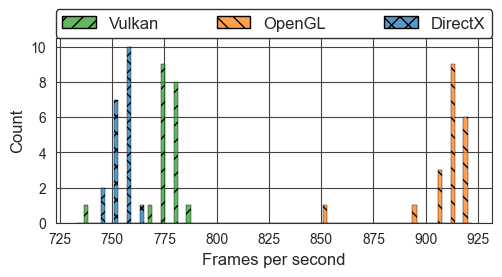

In [37]:
df_cube_120 = df[(df["Model"] == "Cube") & (df["Experiment"] == "2") & (df["Objects count"] == 120)]
avg_fps_config = {"x_column": "Average FPS", "x_label": "Frames per second", "binwidth": 6, "title": "Distribution of FPS for static experient on integrated GPU (120 Cube models)", "plot_range": 2} 
create_distribution_plot(df_cube_120, avg_fps_config, output="../Images/avg-fps-repeated-experiment-2-cube-120-integrated.png")

In [38]:
vulkan_fps = df_cube_120[df_cube_120["Renderer"] == "Vulkan"]["Average FPS"]
opengl_fps = df_cube_120[df_cube_120["Renderer"] == "OpenGL"]["Average FPS"]
directx_fps = df_cube_120[df_cube_120["Renderer"] == "DirectX"]["Average FPS"]

check_normality(filter_outliers(directx_fps))
print()
check_normality(filter_outliers(vulkan_fps))
print()
compare_normal_distributions(filter_outliers(directx_fps), filter_outliers(vulkan_fps))

Filtered length: 20
Shapiro-Wilk Test:
Statistic = 0.752164749388595 p-value = 0.6865457767144498
Normal

Filtered length: 19
Shapiro-Wilk Test:
Statistic = 1.733762549346293 p-value = 0.42026018362990114
Normal

One-tailed Independent T-Test:
t-statistic = -14.0005, p-value = 0.0000
Reject the null hypothesis: data1 has a significantly smaller mean than data2


C:\Users\maksp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [39]:
df[(df["Experiment"] == "2") & (df["Objects count"] == 120)][["Renderer", "Average FPS", "Model"]].groupby(["Renderer", "Model"]).mean()

Average FPS
Renderer Model              
DirectX  Bunny     11.302840
         Cube     757.148200
         Teapot    89.564685
OpenGL   Bunny     12.613335
         Cube     910.112200
         Teapot    99.120705
Vulkan   Bunny     12.200030
         Cube     772.502450
         Teapot    94.105630

In [40]:
filter_outliers(vulkan_fps).mean()

np.float64(774.6093157894737)